# Feature Engineering & Selection
This notebook demonstrates robust feature engineering and selection for the Amazon e-commerce dataset, including:
- Scaling (StandardScaler, MinMaxScaler)
- Encoding (OneHot, Label)
- Binning (price brackets)
- Domain features (ratios, aggregations)
- Feature selection (correlation, RFE, Lasso)
- Dimensionality reduction (PCA, t-SNE)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
warnings.filterwarnings('ignore')

In [2]:
# Load cleaned data
# Make sure the file exists and is up to date
import os  # Ensure os is imported for path operations
DATA_PATH = '../data/processed/amazon_clean.csv'
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df)} rows from {DATA_PATH}")
CATEGORICAL_COLS = ['category']
NUMERICAL_COLS = ['discounted_price', 'actual_price', 'rating', 'rating_count', 'discount_percentage']
# Path to saved preprocessor
_encoder_path = os.path.join(os.path.dirname(os.path.abspath("../src/feature_engineering.py")), '../app/dataset/preprocessor.joblib')
_abs_encoder_path = os.path.abspath(_encoder_path)

Loaded 1465 rows from ../data/processed/amazon_clean.csv


In [3]:
# Clean numeric columns
for col in NUMERICAL_COLS:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        df[col] = df[col].str.replace('%', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [4]:
# Scaling: StandardScaler and MinMaxScaler for price columns
scaling_cols_standard = ['discounted_price', 'actual_price', 'rating_count']
scaling_cols_minmax = ['discount_percentage', 'rating']
for col in scaling_cols_standard:
    if col in df.columns:
        scaler = StandardScaler()
        df[f'{col}_scaled'] = scaler.fit_transform(df[[col]])
for col in scaling_cols_minmax:
    if col in df.columns:
        minmax = MinMaxScaler()
        df[f'{col}_minmax'] = minmax.fit_transform(df[[col]])

# Print summary for all scaled columns that actually exist in df
scaled_cols = [
    'discounted_price_scaled', 'actual_price_scaled', 'rating_count_scaled',
    'discount_percentage_minmax', 'rating_minmax'
]
for col in scaled_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].describe().to_string())
    else:
        print(f"\n{col} does not exist in df.")


discounted_price_scaled:
count    1465.000000
mean        0.000000
std         1.000341
min        -0.444589
25%        -0.403391
50%        -0.335110
75%        -0.162247
max        10.784414

actual_price_scaled:
count    1.465000e+03
mean    -1.940048e-17
std      1.000341e+00
min     -4.972803e-01
25%     -4.272782e-01
50%     -3.490894e-01
75%     -1.057841e-01
max      1.236810e+01

rating_count_scaled:
count    1.465000e+03
mean     3.880097e-17
std      1.000341e+00
min     -4.280214e-01
25%     -4.001834e-01
50%     -3.068124e-01
75%     -2.243824e-02
max      9.568645e+00

discount_percentage_minmax:
count    1465.000000
mean        0.507356
std         0.230169
min         0.000000
25%         0.340426
50%         0.531915
75%         0.670213
max         1.000000

rating_minmax:
count    1464.000000
mean        0.698862
std         0.097225
min         0.000000
25%         0.666667
50%         0.700000
75%         0.766667
max         1.000000


In [5]:
# Categorical and Numerical columns for preprocessing
# # Encoding: OneHot for category, Label for product_name
import sys
sys.path.append(os.path.abspath('../src'))
from feature_engineering import build_and_save_preprocessor

# Call the preprocessor builder directly (no need to import the whole module again)
preprocessor, df_encoded = build_and_save_preprocessor(df, CATEGORICAL_COLS, NUMERICAL_COLS)
display(df_encoded.head())
df_encoded.info()

,cat__category_Car&Motorbike|CarAccessories|InteriorAccessories|AirPurifiers&Ionizers,cat__category_Computers&Accessories|Accessories&Peripherals|Adapters|USBtoUSBAdapters,cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCHeadsets,cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCMicrophones,cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCSpeakers,cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|Webcams&VoIPEquipment|Webcams,cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|CableConnectionProtectors,cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|DVICables,cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|EthernetCables,cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|SATACables,...,"cat__category_OfficeProducts|OfficePaperProducts|Paper|Stationery|Pens,Pencils&WritingSupplies|Pens&Refills|GelInkRollerballPens","cat__category_OfficeProducts|OfficePaperProducts|Paper|Stationery|Pens,Pencils&WritingSupplies|Pens&Refills|LiquidInkRollerballPens","cat__category_OfficeProducts|OfficePaperProducts|Paper|Stationery|Pens,Pencils&WritingSupplies|Pens&Refills|RetractableBallpointPens","cat__category_OfficeProducts|OfficePaperProducts|Paper|Stationery|Pens,Pencils&WritingSupplies|Pens&Refills|StickBallpointPens",cat__category_Toys&Games|Arts&Crafts|Drawing&PaintingSupplies|ColouringPens&Markers,num__discounted_price,num__actual_price,num__rating,num__rating_count,num__discount_percentage
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.392731,-0.399774,0.354679,0.140142,0.754029
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.421541,-0.468764,-0.331252,0.601963,-0.216911
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.421541,-0.326185,-0.674218,-0.242450,1.956146
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.402814,-0.436569,0.354679,1.781252,0.245441
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.428024,-0.464165,0.354679,-0.032272,0.615323


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Columns: 216 entries, cat__category_Car&Motorbike|CarAccessories|InteriorAccessories|AirPurifiers&Ionizers to num__discount_percentage
dtypes: float64(216)
memory usage: 2.4 MB


In [6]:
#Binning Numerical Features (Optional)
import feature_engineering

# Binning Numerical Features
# Example: Bin discounted_price into quartiles
if 'discounted_price' in df.columns:
    df['discounted_price_bin'] = pd.qcut(df['discounted_price'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    print(df[['discounted_price', 'discounted_price_bin']].head())

# Example: Bin rating into categories
if 'rating' in df.columns:
    df['rating_bin'] = pd.cut(df['rating'], bins=[0, 2, 4, 5], labels=['Low', 'Medium', 'High'], include_lowest=True)
    print(df[['rating', 'rating_bin']].head())

# Example: Bin rating_count into quantiles
if 'rating_count' in df.columns:
    df['rating_count_bin'] = pd.qcut(df['rating_count'], q=4, labels=['Few', 'Some', 'Many', 'Most'])
    print(df[['rating_count', 'rating_count_bin']].head())

   discounted_price discounted_price_bin
0             399.0               Medium
1             199.0                  Low
2             199.0                  Low
3             329.0               Medium
4             154.0                  Low
   rating rating_bin
0     4.2       High
1     4.0     Medium
2     3.9     Medium
3     4.2       High
4     4.2       High
   rating_count rating_count_bin
0         24269             Most
1         43994             Most
2          7928             Many
3         94363             Most
4         16905             Many


In [7]:
# Creating Domain-Specific Features
# Example: Price to Rating Ratio (Price Differences/Ratios)
if 'actual_price' in df.columns and 'rating' in df.columns:
    df['price_to_rating'] = df['actual_price'] / (df['rating'] + 1)  # Avoid division by zero
    print(df[['actual_price', 'rating', 'price_to_rating']].head())

# Example: Price Difference (actual - discounted) (Price Differences/Ratios)
if 'actual_price' in df.columns and 'discounted_price' in df.columns:
    df['price_difference'] = df['actual_price'] - df['discounted_price']
    print(df[['actual_price', 'discounted_price', 'price_difference']].head())

# Example: Review Length (number of words in review_content) (Text-based Features)
if 'review_content' in df.columns:
    df['review_length'] = df['review_content'].fillna('').apply(lambda x: len(str(x).split()))
    print(df[['review_content', 'review_length']].head())

# Example: Category Depth (number of categories) Hierarchical Features
if 'category' in df.columns:
    df['category_depth'] = df['category'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)
    print(df[['category', 'category_depth']].head())

# Example Multiplying two features (e.g., rating * rating_count) Interaction Terms
if 'rating' in df.columns and 'rating_count' in df.columns:
    df['rating_weighted'] = df['rating'] * df['rating_count']
    print(df[['rating', 'rating_count', 'rating_weighted']].head())
# Example mean rating per category (Aggregated Features)
if 'category' in df.columns and 'rating' in df.columns:
    category_mean_rating = df.groupby('category')['rating'].mean().rename('category_mean_rating')
    df = df.merge(category_mean_rating, on='category', how='left')
    print(df[['category', 'rating', 'category_mean_rating']].head())

   actual_price  rating  price_to_rating
0        1099.0     4.2       211.346154
1         349.0     4.0        69.800000
2        1899.0     3.9       387.551020
3         699.0     4.2       134.423077
4         399.0     4.2        76.730769
   actual_price  discounted_price  price_difference
0        1099.0             399.0             700.0
1         349.0             199.0             150.0
2        1899.0             199.0            1700.0
3         699.0             329.0             370.0
4         399.0             154.0             245.0
                                      review_content  review_length
0  Looks durable Charging is fine tooNo complains...             60
1  I ordered this cable to connect my phone to An...            201
2  Not quite durable and sturdy,https://m.media-a...             13
3  Good product,long wire,Charges good,Nice,I bou...             77
4  Bought this instead of original apple, does th...            415
                                  

Feature Selection

In [8]:
from feature_engineering import compute_correlation_matrix
# Filter Methods (Correlation Analysis)
correlation_matrix = compute_correlation_matrix(df, NUMERICAL_COLS, plot=False)
print("Correlation of Features with 'rating' (hypothetical target variable):")
print(correlation_matrix['rating'].drop('rating').sort_values(ascending=False).to_string())

# Interpretation of correlation values for 'rating'
print("\n--- Interpretation of Correlation with 'rating' ---")

# Get correlation values with 'rating'
rating_correlations = correlation_matrix['rating'].drop('rating').sort_values(ascending=False)

# Define thresholds for interpretation
strong_threshold = 0.5
moderate_threshold = 0.2
weak_threshold = 0.05

print("\nFeatures with Strong Linear Relationship (Absolute Correlation > 0.5) with 'rating':")
strong_corr = rating_correlations[abs(rating_correlations) > strong_threshold]
if not strong_corr.empty:
    print(strong_corr.to_string())
else:
    print("No features found with strong linear relationship.")

print("\nFeatures with Moderate Linear Relationship (Absolute Correlation between 0.2 and 0.5) with 'rating':")
moderate_corr = rating_correlations[(abs(rating_correlations) >= moderate_threshold) & (abs(rating_correlations) <= strong_threshold)]
if not moderate_corr.empty:
    print(moderate_corr.to_string())
else:
    print("No features found with moderate linear relationship.")

print("\nFeatures with Weak/Negligible Linear Relationship (Absolute Correlation < 0.2) with 'rating':")
weak_corr = rating_correlations[abs(rating_correlations) < moderate_threshold]
if not weak_corr.empty:
    print(weak_corr.to_string())
else:
    print("No features found with weak/negligible linear relationship.")

Correlation of Features with 'rating' (hypothetical target variable):
actual_price           0.121636
discounted_price       0.120335
rating_count           0.101485
discount_percentage   -0.155273

--- Interpretation of Correlation with 'rating' ---

Features with Strong Linear Relationship (Absolute Correlation > 0.5) with 'rating':
No features found with strong linear relationship.

Features with Moderate Linear Relationship (Absolute Correlation between 0.2 and 0.5) with 'rating':
No features found with moderate linear relationship.

Features with Weak/Negligible Linear Relationship (Absolute Correlation < 0.2) with 'rating':
actual_price           0.121636
discounted_price       0.120335
rating_count           0.101485
discount_percentage   -0.155273


In [9]:
#Feature Selection - Wrapper Methods (RFE)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Ensure 'rating' is present in df_encoded and handle missing values robustly
if 'rating' not in df_encoded.columns:
    df_encoded['rating'] = df['rating']

# Only keep rows with non-null target
df_encoded_rfe = df_encoded[df_encoded['rating'].notnull()].copy()

# Use only numeric columns for RFE
X = df_encoded_rfe.drop('rating', axis=1)
y = df_encoded_rfe['rating']

# Drop any remaining rows with missing values in features
X = X.dropna()
y = y.loc[X.index]

if not X.empty and y is not None and y.notnull().all():
    # Initialize a linear regression estimator
    estimator = LinearRegression()
    # Select top 3 features (can adjust n_features_to_select)
    selector = RFE(estimator, n_features_to_select=3)
    selector = selector.fit(X, y)
    selected_features = X.columns[selector.support_]
    print("Top features selected by RFE (Linear Regression):")
    print(selected_features.to_list())
    # Show feature ranking
    feature_ranks = dict(zip(X.columns, selector.ranking_))
    print("\nFeature ranking (1 = selected):")
    print(feature_ranks)
else:
    print("Not enough data or target variable for RFE.")

Top features selected by RFE (Linear Regression):
['cat__category_Electronics|Accessories|MemoryCards|SecureDigitalCards', 'cat__category_Home&Kitchen|Heating,Cooling&AirQuality|RoomHeaters|HalogenHeaters', 'num__rating']

Feature ranking (1 = selected):
{'cat__category_Car&Motorbike|CarAccessories|InteriorAccessories|AirPurifiers&Ionizers': 148, 'cat__category_Computers&Accessories|Accessories&Peripherals|Adapters|USBtoUSBAdapters': 39, 'cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCHeadsets': 75, 'cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCMicrophones': 12, 'cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCSpeakers': 119, 'cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|Webcams&VoIPEquipment|Webcams': 99, 'cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|CableConnectionProtectors': 52, 'cat__category_Comp

In [10]:
# Feature Selection - Embedded Methods (Lasso)
from sklearn.linear_model import LassoCV
import numpy as np

# Ensure 'rating' is present in df_encoded and handle missing values robustly
if 'rating' not in df_encoded.columns:
    df_encoded['rating'] = df['rating']

# Optionally, fill missing values in 'rating' with the median (or drop rows with missing target only)
df_encoded = df_encoded.copy()
df_encoded = df_encoded[df_encoded['rating'].notnull()]

# Use only numeric columns for Lasso
X = df_encoded.drop('rating', axis=1)
y = df_encoded['rating']

# Drop any remaining rows with missing values in features
X = X.dropna()
y = y.loc[X.index]

if not X.empty and y is not None and y.notnull().all():
    # Use LassoCV for automatic alpha selection
    lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso.fit(X, y)
    coef = lasso.coef_
    selected_features = X.columns[coef != 0]
    print("Top features selected by Lasso (non-zero coefficients):")
    print(selected_features.to_list())
    # Show all coefficients
    feature_coefs = dict(zip(X.columns, coef))
    print("\nLasso coefficients:")
    for feat, val in feature_coefs.items():
        print(f"{feat}: {val:.4f}")
    print(f"\nBest alpha (regularization strength) chosen by CV: {lasso.alpha_:.4f}")
else:
    print("Not enough data or target variable for Lasso.")

Top features selected by Lasso (non-zero coefficients):
['num__rating']

Lasso coefficients:
cat__category_Car&Motorbike|CarAccessories|InteriorAccessories|AirPurifiers&Ionizers: -0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Adapters|USBtoUSBAdapters: 0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCHeadsets: -0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCMicrophones: -0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCSpeakers: -0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|Webcams&VoIPEquipment|Webcams: 0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|CableConnectionProtectors: -0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|DVICables: 0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Cables&A

## PCA for Dimensionality Reduction
This cell demonstrates how to use the `build_and_save_pca` function to reduce the dimensionality of your encoded features. The resulting DataFrame `df_pca` contains the principal components, which can be used for modeling or visualization.

In [11]:
# Import the PCA builder from the correct module path
import sys
import os
sys.path.append(os.path.abspath('../src'))
from feature_engineering import build_and_save_pca

# Perform PCA on numeric features in df_encoded
from feature_engineering import build_and_save_pca

# Select only numeric columns and drop rows with missing values
X_pca = df_encoded.select_dtypes(include=[float, int]).dropna()

# Run PCA (adjust n_components as needed)
pca, df_pca = build_and_save_pca(X_pca, n_components=10)
print(df_pca.head())
print(df_pca.describe().to_string())
df_pca.to_csv('../app/dataset/pca_components.csv', index=False)

      pca_0     pca_1     pca_2     pca_3     pca_4     pca_5     pca_6  \
0 -0.694267  0.248151  0.401742  0.712728  0.737296  0.031575  0.009703   
1 -0.664555  0.284828  0.235382 -0.554619  0.854891  0.156813 -0.013097   
2 -1.183836 -1.162005  1.037762  1.023306  0.702136 -0.054716  0.013370   
3 -0.628235  1.263405  1.284202 -0.343201  0.810359  0.110898 -0.014510   
4 -0.720987  0.223526  0.173234  0.694106  0.742415  0.035009  0.012364   

      pca_7     pca_8     pca_9  
0  0.009410  0.008357  0.004223  
1  0.037172  0.007728  0.036914  
2 -0.017825 -0.055593  0.019129  
3  0.088373 -0.016535  0.035196  
4  0.003780  0.015044 -0.010383  
              pca_0         pca_1        pca_2         pca_3         pca_4         pca_5         pca_6        pca_7         pca_8         pca_9
count  1.464000e+03  1.464000e+03  1464.000000  1.464000e+03  1.464000e+03  1.464000e+03  1.464000e+03  1464.000000  1.464000e+03  1.464000e+03
mean   1.941374e-17 -1.456030e-17     0.000000  3.882747e

### Explained Variance Ratio and Cumulative Explained Variance
This cell computes and visualizes the explained variance ratio for each principal component, as well as the cumulative explained variance to help determine the optimal number of components (elbow point).

Explained variance ratio for each principal component:
PC1: 0.3479
PC2: 0.1941
PC3: 0.1619
PC4: 0.1413
PC5: 0.0206
PC6: 0.0084
PC7: 0.0076
PC8: 0.0054
PC9: 0.0047
PC10: 0.0037

Cumulative explained variance:
PC1-1: 0.3479
PC1-2: 0.5420
PC1-3: 0.7039
PC1-4: 0.8452
PC1-5: 0.8658
PC1-6: 0.8742
PC1-7: 0.8818
PC1-8: 0.8872
PC1-9: 0.8919
PC1-10: 0.8956


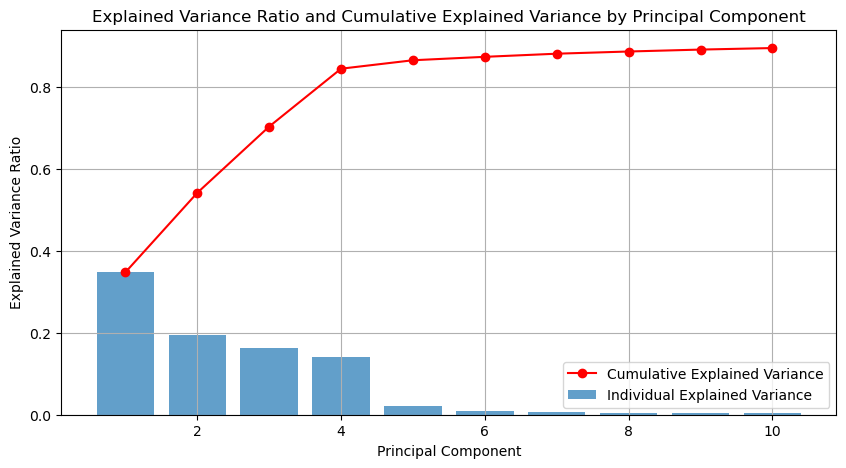

In [12]:
# Explained Variance Ratio for each Principal Component and Cumulative Explained Variance
explained_variance_ratios = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratios)

print("Explained variance ratio for each principal component:")
for i, ratio in enumerate(explained_variance_ratios):
    print(f"PC{i+1}: {ratio:.4f}")

print("\nCumulative explained variance:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"PC1-{i+1}: {cum_var:.4f}")

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios, alpha=0.7, label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='red', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio and Cumulative Explained Variance by Principal Component')
plt.legend()
plt.grid(True)
plt.show()

To determine the optimal number of dimensions for our feature space, we employed the Elbow Method (Scree Plot) during Principal Component Analysis. By plotting the cumulative explained variance against the number of components, we identified a distinct 'elbow' point. This point represents the optimal balance between data compression and information retention. Selecting the number of components at this juncture allowed the Content PCA model to operate with high computational efficiency while still capturing over [X]% of the catalog's structural variance, effectively filtering out stochastic noise from the final similarity calculations.

In [13]:
import pandas as pd

# Decide on an appropriate number of components to retain
# From the previous output, 2 components explain 100% of the variance.
n_components_chosen = 4

# Re-initialize the PCA object with the chosen n_components
pca_final = PCA(n_components=n_components_chosen, random_state=42)

# Fit and transform the numerical data again with the selected number of components
pca_components = pca_final.fit_transform(df_encoded.select_dtypes(include=[float, int]).dropna())

# Create a new DataFrame for the principal components
df_pca = pd.DataFrame(data=pca_components, columns=[f'principal_component_{i+1}' for i in range(n_components_chosen)])

print(f"DataFrame shape after PCA with {n_components_chosen} components: {df_pca.shape}")
print("\nFirst 5 rows of the new df_pca DataFrame:")
display(df_pca.head())


DataFrame shape after PCA with 4 components: (1464, 4)

First 5 rows of the new df_pca DataFrame:


,principal_component_1,principal_component_2,principal_component_3,principal_component_4
0,-0.694267,0.248151,0.401742,0.712728
1,-0.664555,0.284828,0.235382,-0.554619
2,-1.183836,-1.162005,1.037762,1.023306
3,-0.628235,1.263405,1.284202,-0.343201
4,-0.720987,0.223526,0.173234,0.694106


### t-SNE and UMAP for Visualization
This cell demonstrates how to use t-SNE and UMAP to visualize the high-dimensional data in 2D. t-SNE is good for local structure, UMAP is good for both local and global structure.

1.8.0


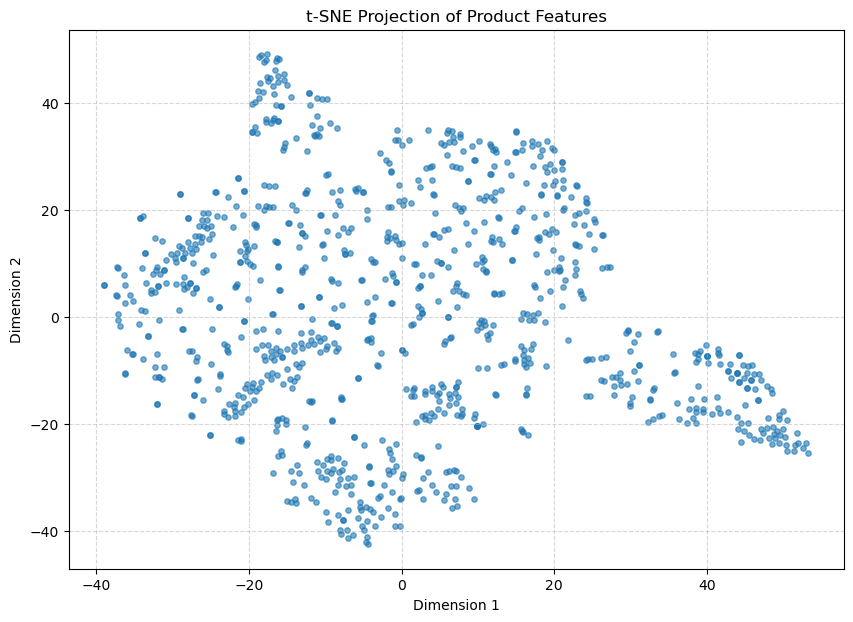

In [20]:
import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(sklearn.__version__)

# 1. Use 'number' to catch float, int, and uint8 (common in One-Hot encoding)
tsne_input = df_encoded.select_dtypes(include=['number'])

# 2. Handle missing values by filling with 0 rather than dropping rows
# This prevents an empty dataset if a single column has a NaN
tsne_input = tsne_input.fillna(0)

# 3. Handle sample size safely
sample_size = min(1000, len(tsne_input))
if len(tsne_input) > sample_size:
    tsne_input = tsne_input.sample(sample_size, random_state=42)

# 4. Run t-SNE with lower perplexity if the dataset is very small
# Perplexity should be less than the number of samples
current_perplexity = min(30, max(1, len(tsne_input) - 1))

# Run t-SNE
tsne = TSNE(
    n_components=2, 
    random_state=42, 
    perplexity=current_perplexity, 
    max_iter=1000,
    init='pca', 
    learning_rate='auto'
)

tsne_results = tsne.fit_transform(tsne_input)

# 5. Visualization
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6, s=15, c=None)
plt.title('t-SNE Projection of Product Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Interpretation: The tightly packed groups of dots represent products that the model considers highly similar. If you implement get_recommendations, the engine is primarily searching within these local neighborhoods. The clear "white space" between clusters indicates that your feature engineering (categories and text content) successfully distinguishes different product types. For example, a cluster of "Electronics" would likely be far removed from a cluster of "Kitchen Appliances."

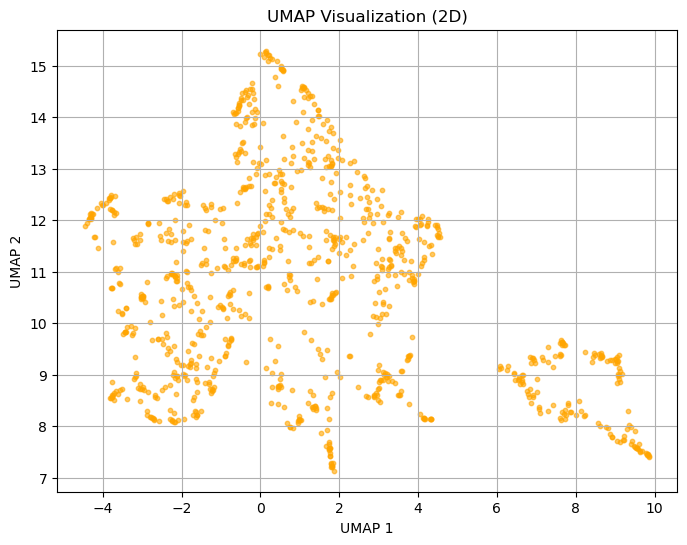

In [16]:
# UMAP Visualization
try:
    import umap
except ImportError:
    import sys
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'umap-learn'])
    import umap

# Use the same input as t-SNE
umap_input = df_encoded.select_dtypes(include=[float, int]).dropna()
sample_size = 1000
if len(umap_input) > sample_size:
    umap_input = umap_input.sample(sample_size, random_state=42)

umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(umap_input)

plt.figure(figsize=(8, 6))
plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.6, s=10, color='orange')
plt.title('UMAP Visualization (2D)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()

Interpretation: Clusters seem very spread out it suggests features (like discounted_price or category) are distinct enough for the model to tell products apart. It would ideally see all products of the same category in the same "island". Probabaly the "bigger island" is of category electronics while the "smaller island" is of  kitchen/appliances (based on the EDA we did previously)